Páginas:


- https://jian.sh/aita/
- https://github.com/JianLoong/reddit-store
- https://www.kaggle.com/datasets/jianloongliew/reddit/data

In [1]:
import sqlite3
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report


In [2]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("data/AmITheAsshole.sqlite")
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())


[('submission',), ('comment',)]


In [3]:
cursor.execute("PRAGMA table_info(submission);")
print("Submission table:")
print(cursor.fetchall())

cursor.execute("PRAGMA table_info(comment);")
print("Comment table:")
print(cursor.fetchall())


Submission table:
[(0, 'id', 'INTEGER', 1, None, 1), (1, 'submission_id', 'VARCHAR(255)', 1, None, 0), (2, 'title', 'TEXT', 1, None, 0), (3, 'selftext', 'TEXT', 1, None, 0), (4, 'created_utc', 'DATE', 1, None, 0), (5, 'permalink', 'TEXT', 1, None, 0), (6, 'score', 'INTEGER', 1, None, 0)]
Comment table:
[(0, 'id', 'INTEGER', 1, None, 1), (1, 'submission_id', 'INTEGER', 1, None, 0), (2, 'message', 'TEXT', 1, None, 0), (3, 'comment_id', 'VARCHAR(255)', 1, None, 0), (4, 'parent_id', 'VARCHAR(255)', 1, None, 0), (5, 'created_utc', 'DATE', 1, None, 0), (6, 'score', 'INTEGER', 1, None, 0)]


In [4]:
df_sub = pd.read_sql_query("SELECT * FROM submission LIMIT 5;", conn)
print(df_sub)


   id submission_id                                              title  \
0   1        xt1ksm            AITA Monthly Open Forum Spooktober 2022   
1   2        yiplwk  AITA for asking my friend to move a picture of...   
2   3        yiv572  AITA for asking my husband to stay with me whi...   
3   4        yimgaf  AITA for telling my SIL to stop talking about ...   
4   5        yin7pf  AITA for wanting to meet my "daughter" after g...   

                                            selftext  created_utc  \
0  #Keep things civil. Rules still apply.\n\n##Th...   1664646465   
1  \n\nMe (M32) and my wife, Dahlia (F28) lost ou...   1667251988   
2  Throwaway my family knows my account. I'll get...   1667266450   
3  My (37M) wife (37F) is pregnant with our first...   1667245059   
4  Long story short: in my (40f) twenties I had a...   1667246573   

                                           permalink  score  
0  /r/AmItheAsshole/comments/xt1ksm/aita_monthly_...    592  
1  /r/AmItheAssh

In [5]:
df_submissions = pd.read_sql_query("SELECT submission_id, title, selftext FROM submission;", conn)
df_comments = pd.read_sql_query("SELECT submission_id, message FROM comment;", conn)

In [6]:
print(len(df_comments))
print(len(df_submissions))

9101374
30994


In [7]:
verdict_keywords = ['NTA', 'YTA', 'ESH', 'NAH', 'INFO']

def extract_verdict(msg):
    msg = msg.upper()
    for word in verdict_keywords:
        if word in msg.split():
            return word
    return None

df_comments['label'] = df_comments['message'].apply(extract_verdict)
df_comments = df_comments[df_comments['label'].notnull()]


In [8]:
submission_verdicts = df_comments.groupby('submission_id')['label'].apply(lambda x: Counter(x).most_common(1)[0][0]).reset_index()

df_merged = df_submissions.merge(submission_verdicts, on='submission_id')
df_merged['text'] = df_merged['title'] + ' ' + df_merged['selftext']


In [9]:
df_merged

,submission_id,title,selftext,label,text
0,xt1ksm,AITA Monthly Open Forum Spooktober 2022,#Keep things civil. Rules still apply.\n\n##Th...,NTA,AITA Monthly Open Forum Spooktober 2022 #Keep ...
1,yiplwk,AITA for asking my friend to move a picture of...,"\n\nMe (M32) and my wife, Dahlia (F28) lost ou...",YTA,AITA for asking my friend to move a picture of...
2,yiv572,AITA for asking my husband to stay with me whi...,Throwaway my family knows my account. I'll get...,YTA,AITA for asking my husband to stay with me whi...
3,yimgaf,AITA for telling my SIL to stop talking about ...,My (37M) wife (37F) is pregnant with our first...,NTA,AITA for telling my SIL to stop talking about ...
4,yin7pf,"AITA for wanting to meet my ""daughter"" after g...",Long story short: in my (40f) twenties I had a...,YTA,"AITA for wanting to meet my ""daughter"" after g..."
...,...,...,...,...,...
30747,17vg85i,AITA for saying to my wife that I’m the one wh...,My (43M) niece (14F) is being raised by my wif...,YTA,AITA for saying to my wife that I’m the one wh...
30748,17v5nna,AITA for snapping at BIL for accusing me of st...,I (48M) was recently at my sister’s (33F) hous...,NTA,AITA for snapping at BIL for accusing me of st...
30749,17v959p,AITA for planning a spotlight dance with just ...,I (25M) will be getting married to my amazing ...,NTA,AITA for planning a spotlight dance with just ...
30750,17ventx,AITA for telling my parents that my siblings a...,"I’m catching flak from this from all sides, bu...",NTA,AITA for telling my parents that my siblings a...


In [10]:
from sklearn.utils import resample

df_majority = df_merged[df_merged['label'] == 'NTA']
df_minority = df_merged[df_merged['label'] != 'NTA']

df_majority_downsampled = resample(df_majority, 
                                   replace=False,    
                                   n_samples=len(df_minority),
                                   random_state=42)  

df_balanced = pd.concat([df_majority_downsampled, df_minority])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['label'].value_counts())

label
NTA     5907
YTA     5449
ESH      241
NAH      160
INFO      57
Name: count, dtype: int64


In [11]:
X = df_balanced['text']
y = df_balanced['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=20000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [13]:
model = MultinomialNB()
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         ESH       0.00      0.00      0.00        53
        INFO       0.00      0.00      0.00         9
         NAH       0.00      0.00      0.00        34
         NTA       0.53      0.87      0.66      1162
         YTA       0.63      0.27      0.37      1105

    accuracy                           0.55      2363
   macro avg       0.23      0.23      0.21      2363
weighted avg       0.56      0.55      0.50      2363



/Users/jdsm/Desktop/pythonVenvs/mlt/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jdsm/Desktop/pythonVenvs/mlt/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jdsm/Desktop/pythonVenvs/mlt/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

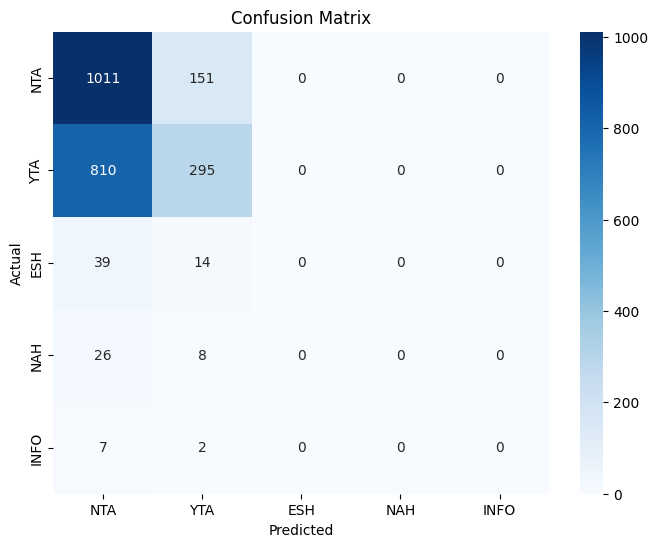

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=verdict_keywords)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=verdict_keywords, yticklabels=verdict_keywords, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
import joblib
joblib.dump(model, 'modelo_naivebayes.pkl')

['modelo_naivebayes.pkl']

In [16]:
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']